In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
%matplotlib inline

In [8]:
#@title
from math import floor
import numpy as np

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])
class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal
        
        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):
                        
                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)
      
    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):
            
            p += self.P[state, next_state, action]
            
            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]

In [9]:
#@title
def create_env(start_state = np.array([[3,6]]), p = 0.7, wind = False):
  # specify world parameters
  num_cols = 10
  num_rows = 10
  obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
  bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
  restart_states = np.array([[3,7],[8,2]])
  goal_states = np.array([[0,9],[2,2],[8,7]])

  # create model
  gw = GridWorld(num_rows=num_rows,
                 num_cols=num_cols,
                 start_state=start_state,
                 goal_states=goal_states, wind = wind) # wind = True
  gw.add_obstructions(obstructed_states=obstructions,
                      bad_states=bad_states,
                      restart_states=restart_states)
  gw.add_rewards(step_reward=-1,
                 goal_reward=10,
                 bad_state_reward=-6,
                 restart_state_reward=-10)
  gw.add_transition_probability(p_good_transition=p, # 1.0
                                bias=0.5)
  env = gw.create_gridworld()
  return env 

In [10]:
#@title
def plot_Q(Q, message = "Q plot"):
    
    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()
    def x_direct(a):
        if a in [UP, DOWN]:
            return 0
        return 1 if a == RIGHT else -1
    def y_direct(a):
        if a in [RIGHT, LEFT]:
            return 0
        return 1 if a == UP else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.show()

def plot_visits(visits, message = "Average visits to each state"):
    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(visits, edgecolors='k', linewidths=2)
    plt.colorbar()
    plt.show()

In [11]:
#@title
from scipy.special import softmax

seed = 42
rg = np.random.RandomState(seed)

# Epsilon greedy
def choose_action_epsilon(Q, state, beta = 0.1, rg=rg):
    if not Q[state[0], state[1]].any() or rg.rand() < beta:
        return rg.choice(Q.shape[-1])
    else:
        return np.argmax(Q[state[0], state[1]])

# Softmax
def choose_action_softmax(Q, state, beta = 1, rg=rg):
    return rg.choice(Q.shape[-1], p = softmax(Q[state[0], state[1]]/beta))

In [12]:
#@title
print_freq = 100

def sarsa(env, Q, gamma = 0.9, plot_heat = False, beta = 1, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    visits = np.zeros(Q.shape[:-1])
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = seq_to_col_row(env.reset(), num_cols)
        visits[state[0, 0], state[0, 1]] += 1
        action = choose_action(Q, [state[0, 0], state[0, 1]], beta = beta)
        done = False
        while not done:
            state_next, reward = env.step(row_col_to_seq(state, num_cols), action)
            state_next = seq_to_col_row(state_next, num_cols)
            visits[state_next[0, 0], state_next[0, 1]] += 1
            reward = reward[0]
            action_next = choose_action(Q, [state_next[0, 0], state_next[0, 1]], beta = beta)
            
            # update equation
            Q[state[0, 0], state[0, 1], action] += alpha*(reward + gamma*Q[state_next[0, 0], state_next[0, 1], action_next] - Q[state[0, 0], state[0, 1], action])
                                                    
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next
            if steps == 100 or reward == 10:
              done = True
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
                
    return Q, episode_rewards, steps_to_completion, visits

In [13]:
# specify world parameters
num_cols = 10
num_rows = 10
DOWN = 0
UP = 1
LEFT = 2
RIGHT = 3
actions = [DOWN, UP, LEFT, RIGHT]

## Configuration 1

In [14]:
env = create_env()

print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

fun = choose_action_softmax

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


In [15]:
alpha0 = 0.1
gamma = 0.99
beta = 0.05
epsilon0 = 0.05
episodes = 10000

In [16]:
Q_avgs, reward_avgs, steps_avgs, visits_avgs = [], [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((num_rows, num_cols, len(actions)))
    rg = np.random.RandomState(i)
    Q, rewards, steps, visits = sarsa(env, Q, gamma = gamma, choose_action = fun, beta = beta)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)
    visits_avgs.append(visits)

Experiment: 1


100%|██████████| 10000/10000 [01:03<00:00, 157.43it/s]


Experiment: 2


100%|██████████| 10000/10000 [01:11<00:00, 139.36it/s]


Experiment: 3


100%|██████████| 10000/10000 [01:27<00:00, 113.88it/s]


Experiment: 4


100%|██████████| 10000/10000 [01:27<00:00, 114.72it/s]


Experiment: 5


100%|██████████| 10000/10000 [01:03<00:00, 157.61it/s]


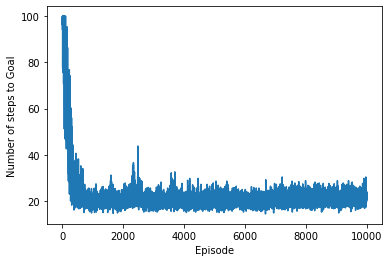

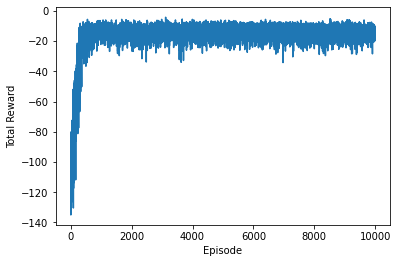

In [17]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

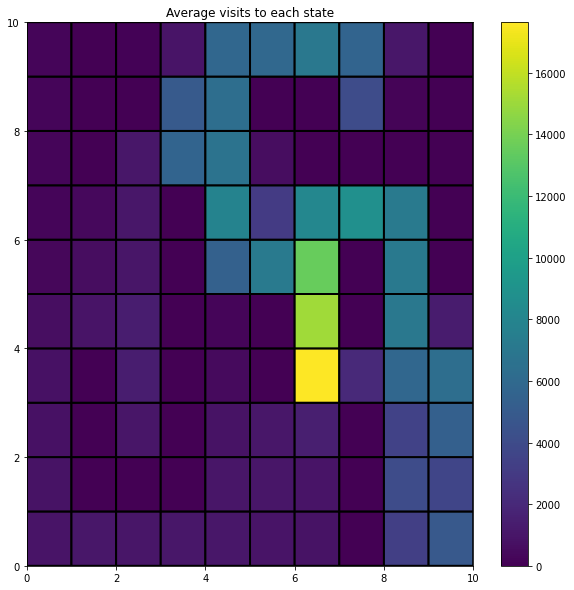

In [18]:
plot_visits(np.average(visits_avgs, 0))

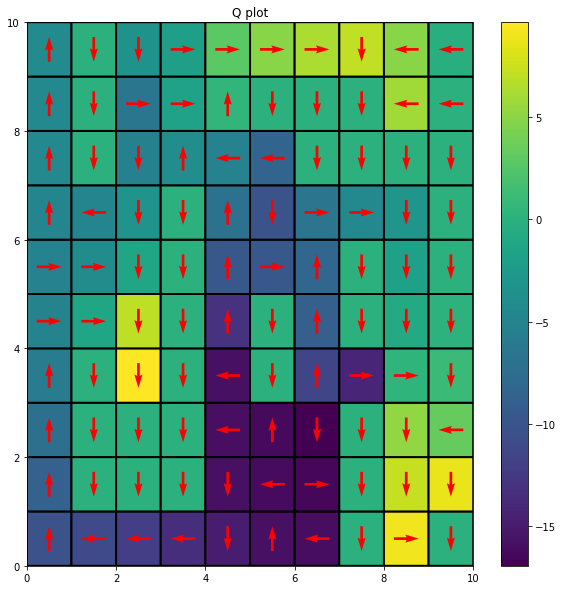

In [19]:
plot_Q(Q)

## Configuration 2

In [20]:
env = create_env()

print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

fun = choose_action_epsilon

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


In [21]:
alpha0 = 0.1
gamma = 0.99
beta = 0.05
epsilon0 = 0.05
episodes = 10000

In [22]:
Q_avgs, reward_avgs, steps_avgs, visits_avgs = [], [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((num_rows, num_cols, len(actions)))
    rg = np.random.RandomState(i)
    Q, rewards, steps, visits = sarsa(env, Q, gamma = gamma, choose_action = fun, beta = epsilon0)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)
    visits_avgs.append(visits)

Experiment: 1


100%|██████████| 10000/10000 [01:02<00:00, 160.48it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:52<00:00, 189.17it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:55<00:00, 181.49it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:56<00:00, 178.17it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:54<00:00, 183.34it/s]


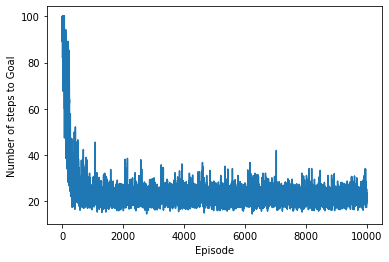

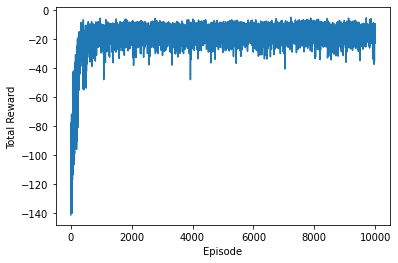

In [23]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

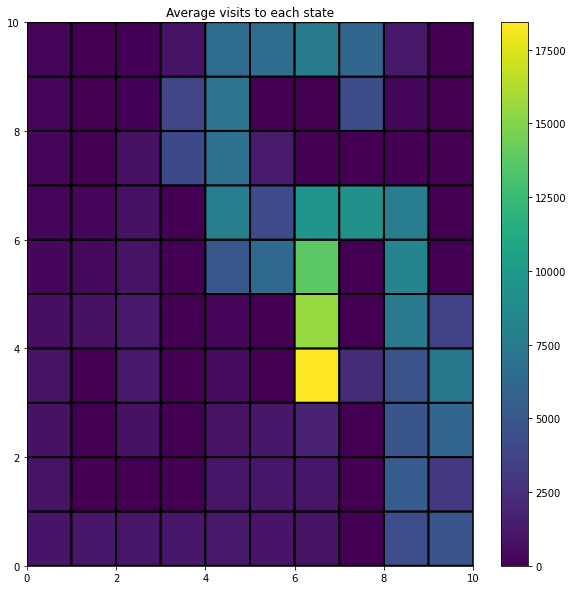

In [24]:
plot_visits(np.average(visits_avgs, 0))

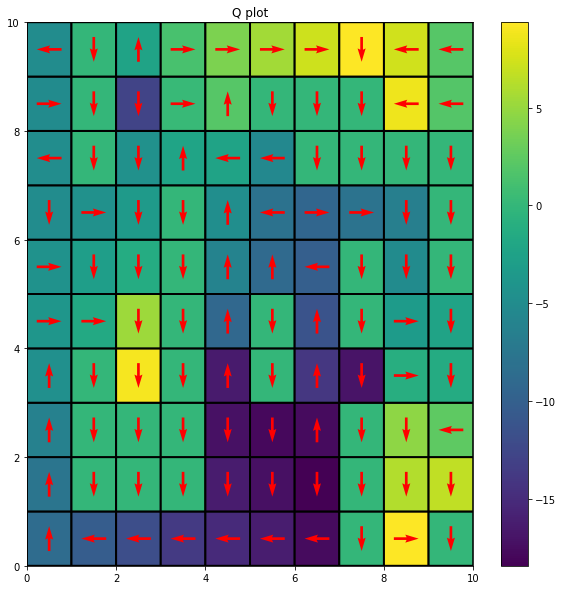

In [25]:
plot_Q(Q)

## Configuration 3

In [26]:
env = create_env(p = 1)

print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

fun = choose_action_softmax

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


In [27]:
alpha0 = 0.1
gamma = 0.99
beta = 0.05
epsilon0 = 0.05
episodes = 10000

In [28]:
Q_avgs, reward_avgs, steps_avgs, visits_avgs = [], [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((num_rows, num_cols, len(actions)))
    rg = np.random.RandomState(i)
    Q, rewards, steps, visits = sarsa(env, Q, gamma = gamma, choose_action = fun, beta = beta)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)
    visits_avgs.append(visits)

Experiment: 1


100%|██████████| 10000/10000 [00:52<00:00, 191.85it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:52<00:00, 191.95it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:52<00:00, 191.35it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:51<00:00, 193.00it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:51<00:00, 193.42it/s]


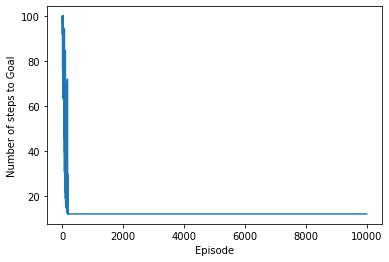

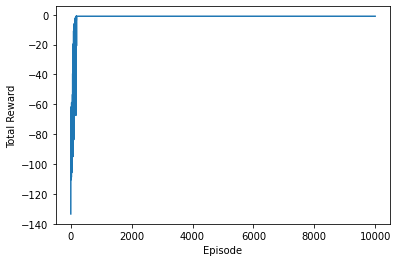

In [29]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

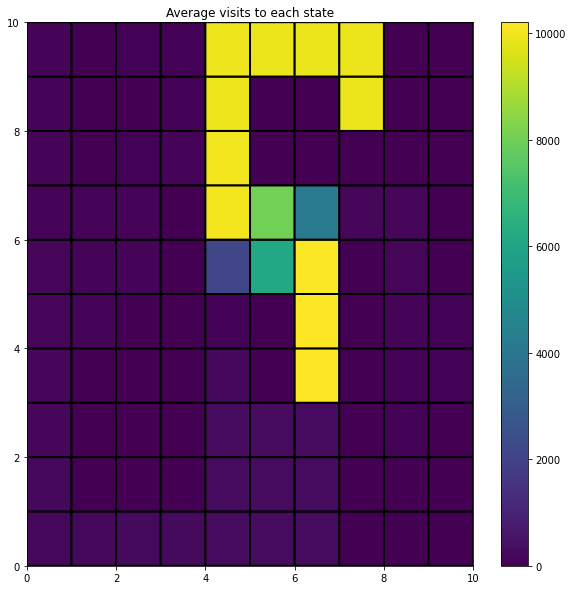

In [30]:
plot_visits(np.average(visits_avgs, 0))

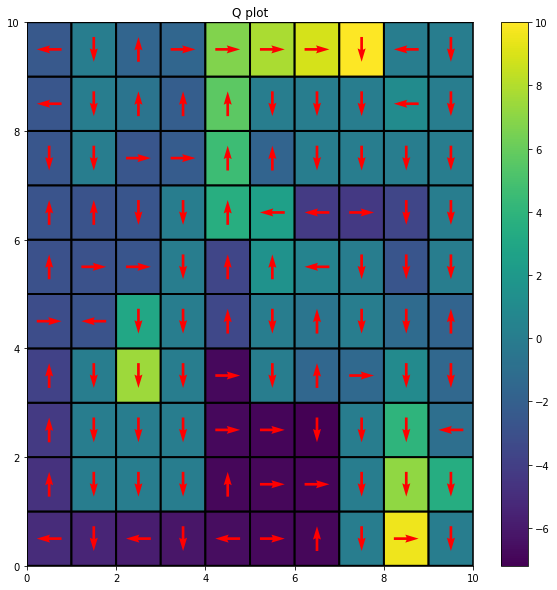

In [31]:
plot_Q(Q)

## Configuration 4

In [32]:
env = create_env(p = 1)

print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

fun = choose_action_epsilon

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


In [33]:
alpha0 = 0.1
gamma = 0.99
beta = 0.05
epsilon0 = 0.05
episodes = 10000

In [34]:
Q_avgs, reward_avgs, steps_avgs, visits_avgs = [], [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((num_rows, num_cols, len(actions)))
    rg = np.random.RandomState(i)
    Q, rewards, steps, visits = sarsa(env, Q, gamma = gamma, choose_action = fun, beta = epsilon0)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)
    visits_avgs.append(visits)

Experiment: 1


100%|██████████| 10000/10000 [00:42<00:00, 237.87it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:41<00:00, 239.37it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:42<00:00, 234.55it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:41<00:00, 239.11it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:42<00:00, 236.89it/s]


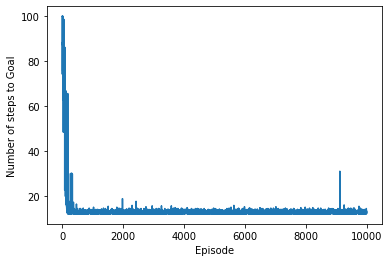

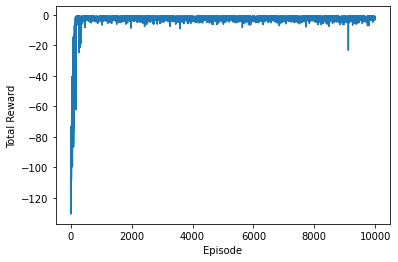

In [35]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

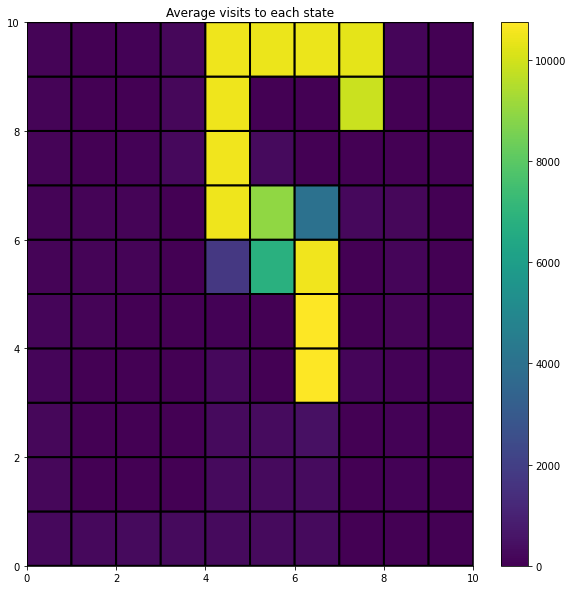

In [36]:
plot_visits(np.average(visits_avgs, 0))

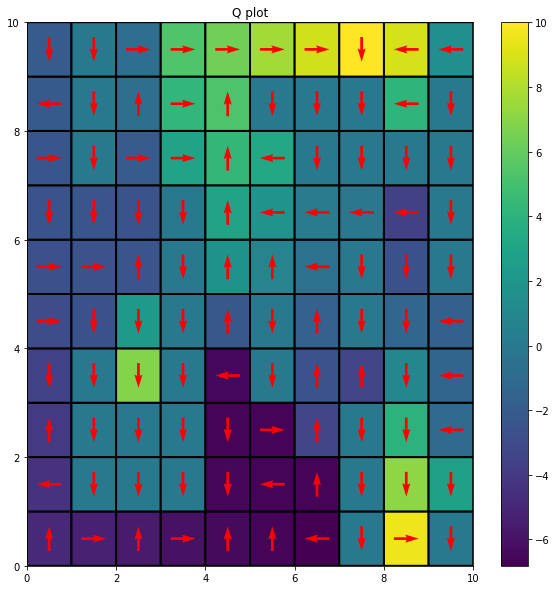

In [37]:
plot_Q(Q)

## Configuration 5

In [38]:
env = create_env(start_state = np.array([[0, 4]]))

print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

fun = choose_action_softmax

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


In [39]:
alpha0 = 0.1
gamma = 0.99
beta = 0.05
epsilon0 = 0.05
episodes = 10000

In [40]:
Q_avgs, reward_avgs, steps_avgs, visits_avgs = [], [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((num_rows, num_cols, len(actions)))
    rg = np.random.RandomState(i)
    Q, rewards, steps, visits = sarsa(env, Q, gamma = gamma, choose_action = fun, beta = beta)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)
    visits_avgs.append(visits)

Experiment: 1


100%|██████████| 10000/10000 [00:43<00:00, 230.91it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:43<00:00, 230.66it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:43<00:00, 231.67it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:43<00:00, 229.62it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:42<00:00, 237.29it/s]


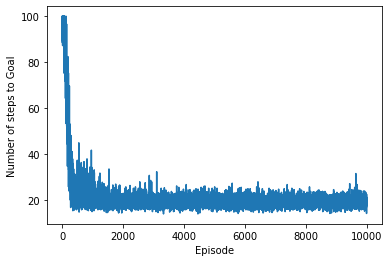

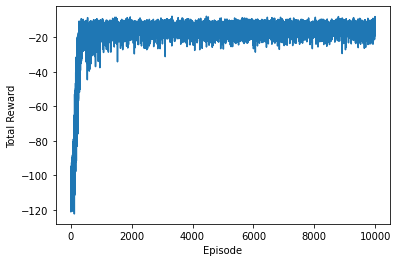

In [41]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

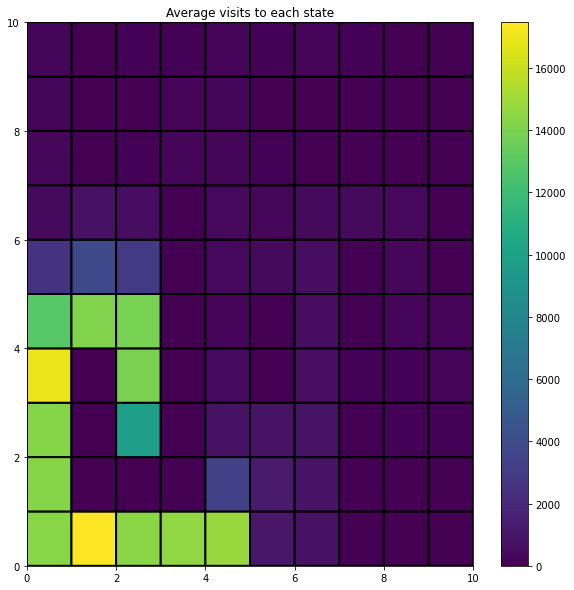

In [42]:
plot_visits(np.average(visits_avgs, 0))

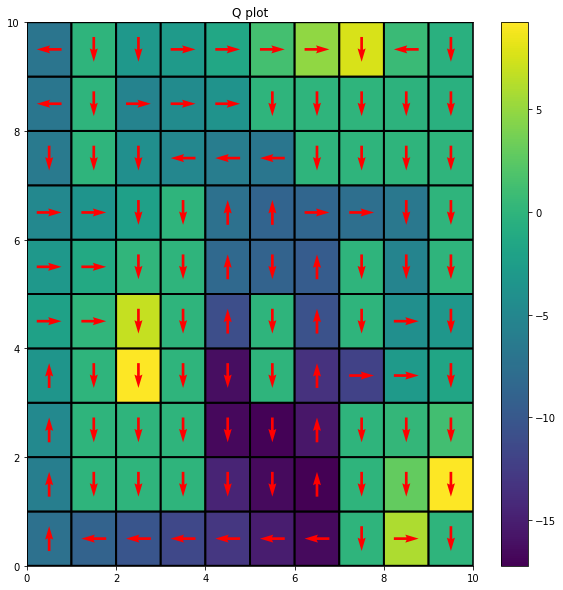

In [43]:
plot_Q(Q)

## Configuration 6

In [44]:
env = create_env(start_state = np.array([[0, 4]]))

print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

fun = choose_action_epsilon

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


In [45]:
alpha0 = 0.1
gamma = 0.99
beta = 0.05
epsilon0 = 0.05
episodes = 10000

In [46]:
Q_avgs, reward_avgs, steps_avgs, visits_avgs = [], [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((num_rows, num_cols, len(actions)))
    rg = np.random.RandomState(i)
    Q, rewards, steps, visits = sarsa(env, Q, gamma = gamma, choose_action = fun, beta = epsilon0)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)
    visits_avgs.append(visits)

Experiment: 1


100%|██████████| 10000/10000 [00:26<00:00, 376.72it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:26<00:00, 377.72it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:26<00:00, 373.26it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:26<00:00, 378.66it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:26<00:00, 376.24it/s]


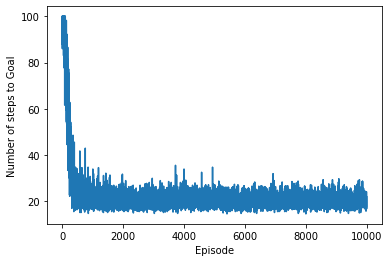

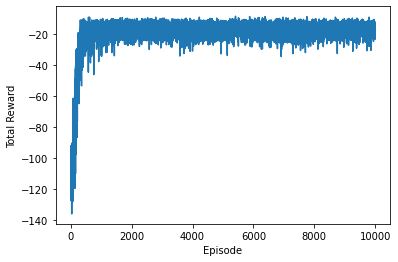

In [47]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

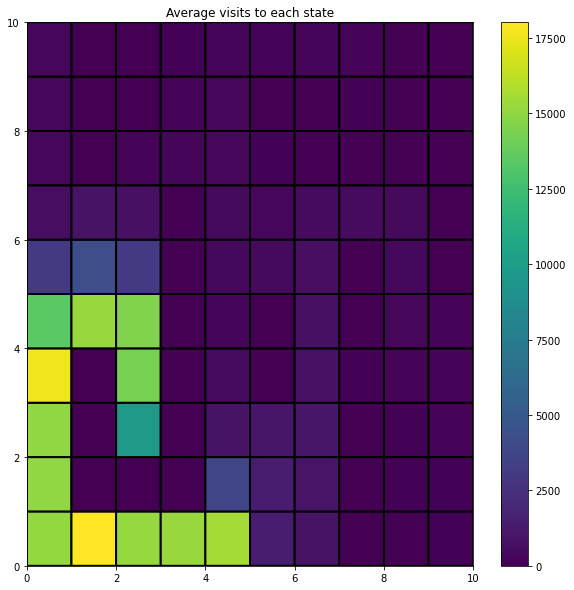

In [48]:
plot_visits(np.average(visits_avgs, 0))

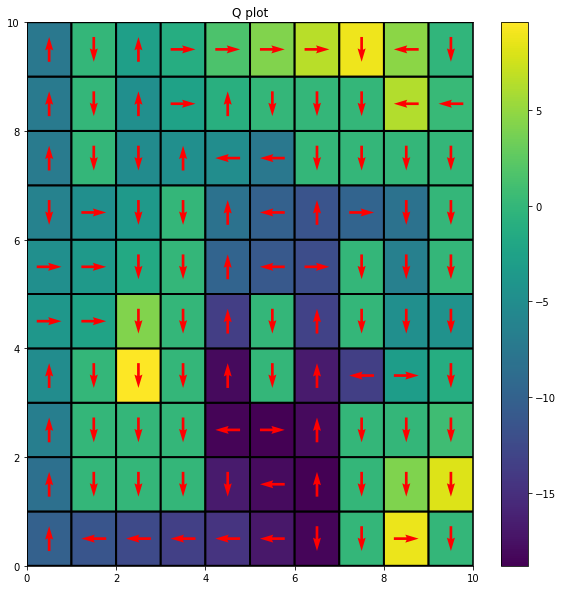

In [49]:
plot_Q(Q)

## Configuration 7

In [50]:
env = create_env(start_state = np.array([[0, 4]]), p = 1)

print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

fun = choose_action_softmax

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


In [51]:
alpha0 = 0.1
gamma = 0.99
beta = 0.05
epsilon0 = 0.05
episodes = 10000

In [52]:
Q_avgs, reward_avgs, steps_avgs, visits_avgs = [], [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((num_rows, num_cols, len(actions)))
    rg = np.random.RandomState(i)
    Q, rewards, steps, visits = sarsa(env, Q, gamma = gamma, choose_action = fun, beta = beta)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)
    visits_avgs.append(visits)

Experiment: 1


100%|██████████| 10000/10000 [00:27<00:00, 369.61it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:26<00:00, 375.65it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:26<00:00, 373.23it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:27<00:00, 369.87it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:26<00:00, 372.13it/s]


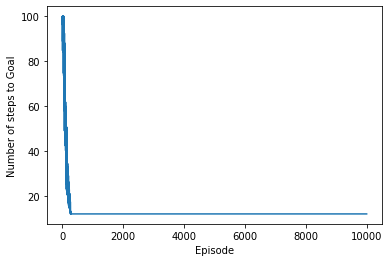

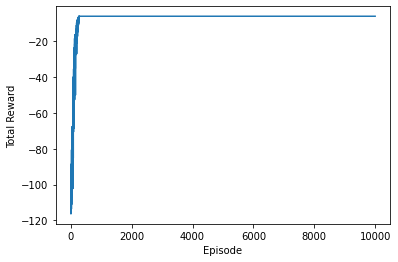

In [53]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

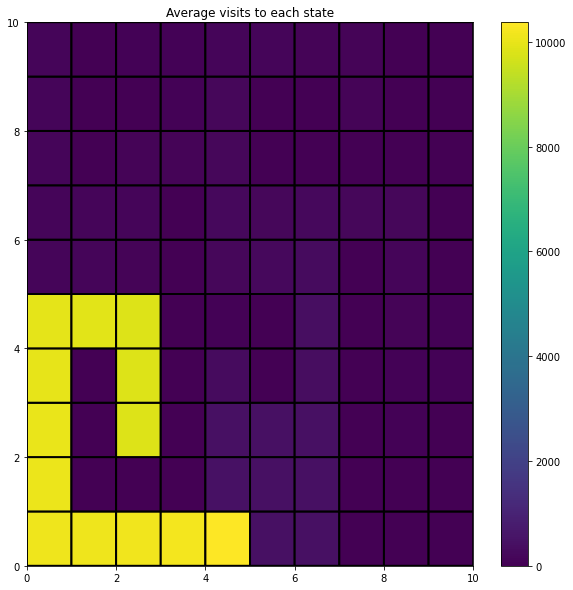

In [54]:
plot_visits(np.average(visits_avgs, 0))

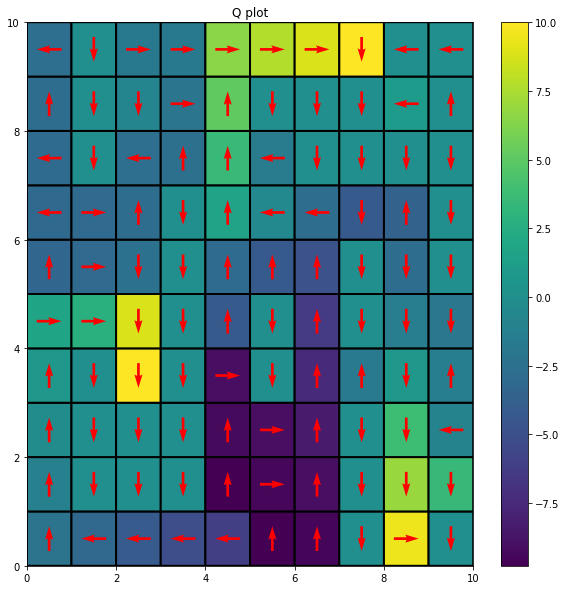

In [55]:
plot_Q(Q)

## Configuration 8

In [56]:
env = create_env(start_state = np.array([[0, 4]]), p = 1)

print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

fun = choose_action_epsilon

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


In [57]:
alpha0 = 0.1
gamma = 0.99
beta = 0.05
epsilon0 = 0.05
episodes = 10000

In [58]:
Q_avgs, reward_avgs, steps_avgs, visits_avgs = [], [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((num_rows, num_cols, len(actions)))
    rg = np.random.RandomState(i)
    Q, rewards, steps, visits = sarsa(env, Q, gamma = gamma, choose_action = fun, beta = epsilon0)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)
    visits_avgs.append(visits)

Experiment: 1


100%|██████████| 10000/10000 [00:16<00:00, 615.17it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:16<00:00, 619.38it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:16<00:00, 619.48it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:16<00:00, 624.65it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:15<00:00, 625.43it/s]


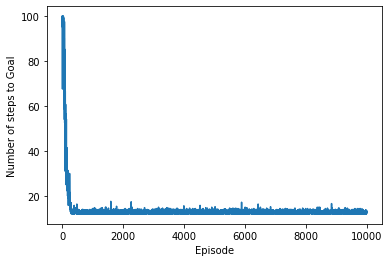

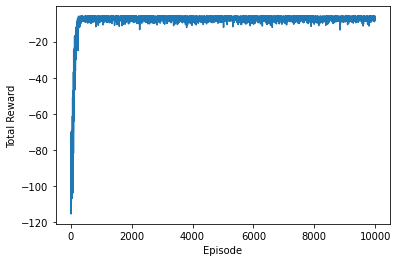

In [59]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

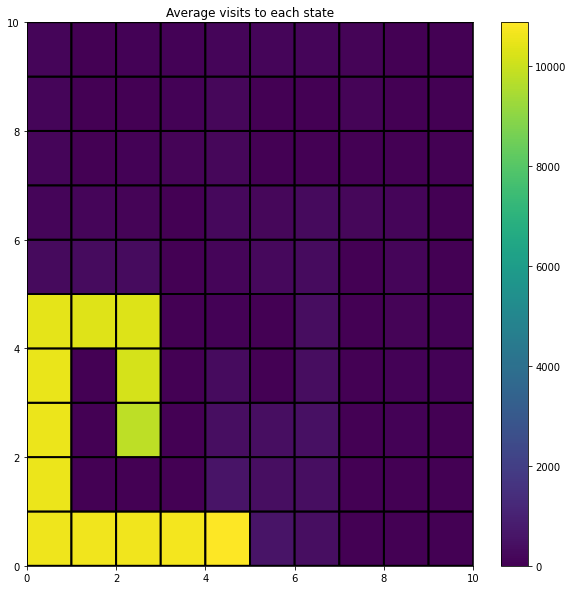

In [60]:
plot_visits(np.average(visits_avgs, 0))

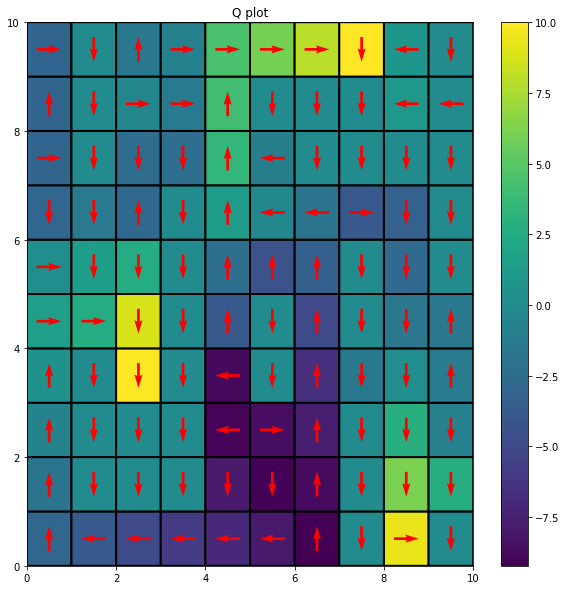

In [61]:
plot_Q(Q)

## Configuration 9

In [62]:
env = create_env(wind = True)

print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

fun = choose_action_softmax

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


In [63]:
alpha0 = 0.1
gamma = 0.95
beta = 0.15
epsilon0 = 0.01
episodes = 10000

In [64]:
Q_avgs, reward_avgs, steps_avgs, visits_avgs = [], [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((num_rows, num_cols, len(actions)))
    rg = np.random.RandomState(i)
    Q, rewards, steps, visits = sarsa(env, Q, gamma = gamma, choose_action = fun, beta = beta)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)
    visits_avgs.append(visits)

Experiment: 1


100%|██████████| 10000/10000 [00:52<00:00, 192.14it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:53<00:00, 188.38it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:53<00:00, 188.00it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:53<00:00, 188.33it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:52<00:00, 191.40it/s]


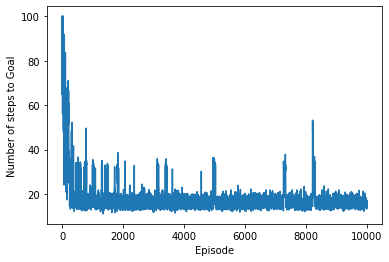

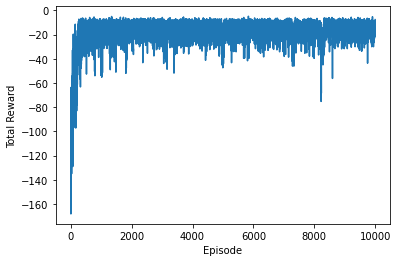

In [65]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

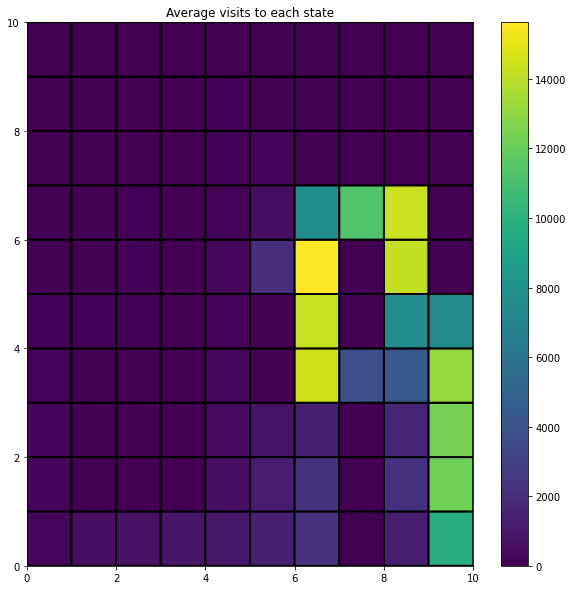

In [66]:
plot_visits(np.average(visits_avgs, 0))

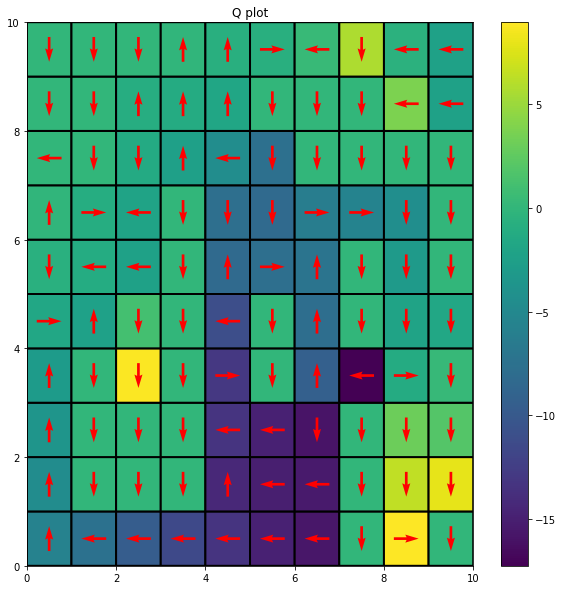

In [67]:
plot_Q(Q)

## Configuration 10

In [68]:
env = create_env(wind = True)

print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

fun = choose_action_epsilon

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


In [69]:
alpha0 = 0.1
gamma = 0.95
beta = 0.15
epsilon0 = 0.01
episodes = 10000

In [70]:
Q_avgs, reward_avgs, steps_avgs, visits_avgs = [], [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((num_rows, num_cols, len(actions)))
    rg = np.random.RandomState(i)
    Q, rewards, steps, visits = sarsa(env, Q, gamma = gamma, choose_action = fun, beta = epsilon0)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)
    visits_avgs.append(visits)

Experiment: 1


100%|██████████| 10000/10000 [00:36<00:00, 272.07it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:36<00:00, 274.55it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:36<00:00, 273.72it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:36<00:00, 273.59it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:37<00:00, 269.93it/s]


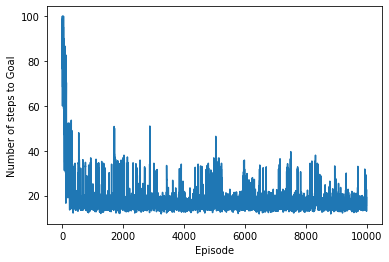

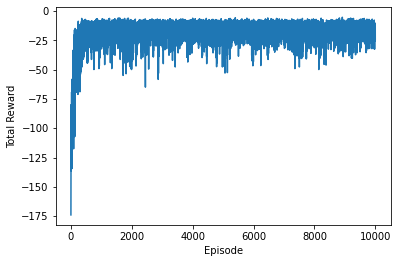

In [71]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

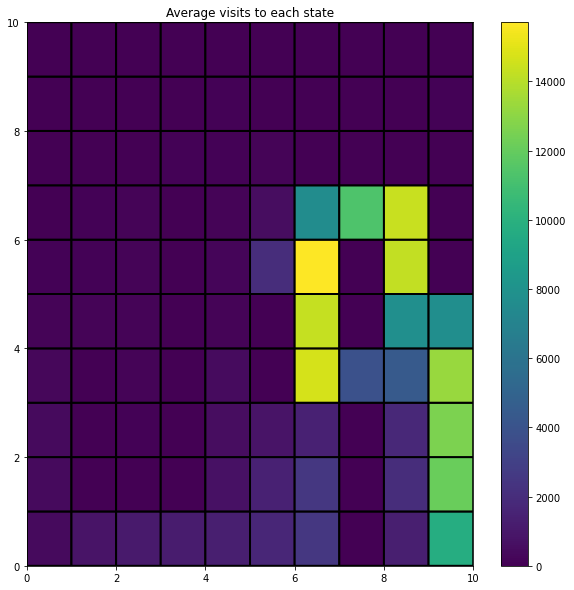

In [72]:
plot_visits(np.average(visits_avgs, 0))

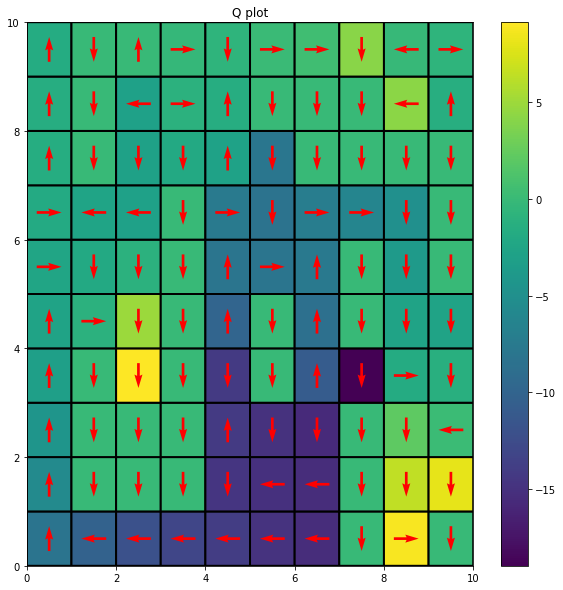

In [73]:
plot_Q(Q)

## Configuration 11

In [74]:
env = create_env(p = 1, wind = True)

print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

fun = choose_action_softmax

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


In [75]:
alpha0 = 0.1
gamma = 0.95
beta = 0.15
epsilon0 = 0.01
episodes = 10000

In [76]:
Q_avgs, reward_avgs, steps_avgs, visits_avgs = [], [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((num_rows, num_cols, len(actions)))
    rg = np.random.RandomState(i)
    Q, rewards, steps, visits = sarsa(env, Q, gamma = gamma, choose_action = fun, beta = beta)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)
    visits_avgs.append(visits)

Experiment: 1


100%|██████████| 10000/10000 [00:33<00:00, 296.54it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:34<00:00, 291.82it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:33<00:00, 300.12it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:33<00:00, 296.45it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:33<00:00, 300.33it/s]


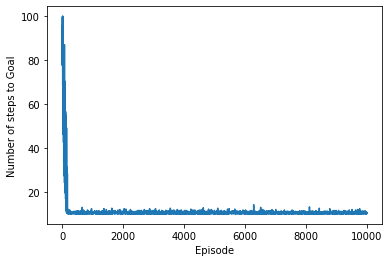

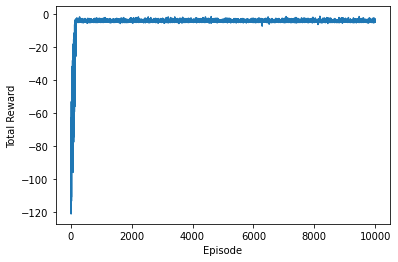

In [77]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

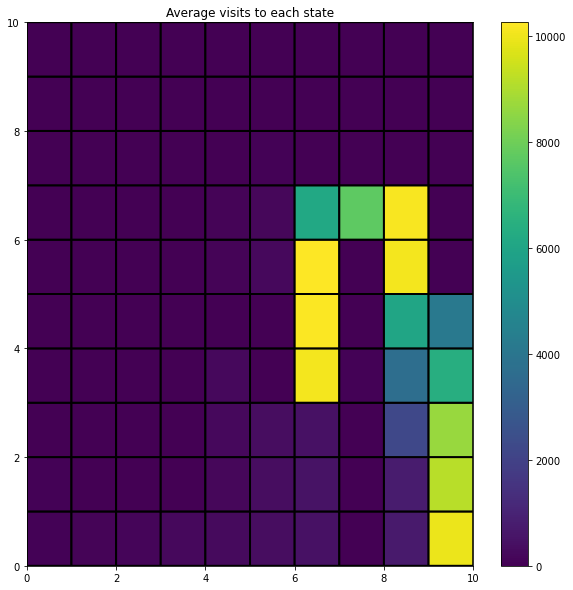

In [78]:
plot_visits(np.average(visits_avgs, 0))

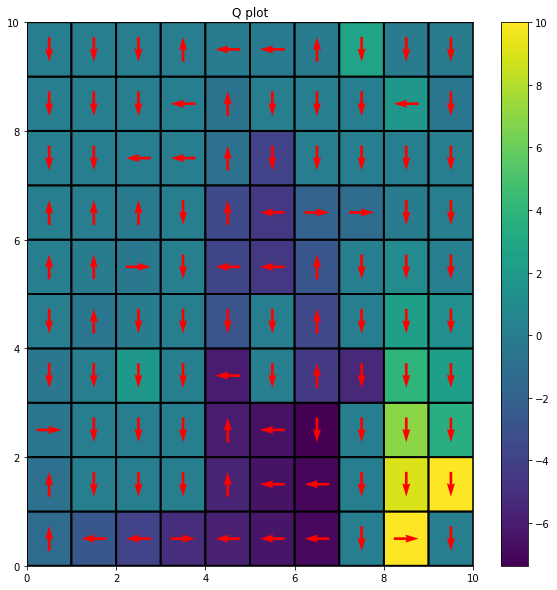

In [79]:
plot_Q(Q)

## Configuration 12

In [80]:
env = create_env(p = 1, wind = True)

print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

fun = choose_action_epsilon

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


In [81]:
alpha0 = 0.1
gamma = 0.95
beta = 0.15
epsilon0 = 0.01
episodes = 10000

In [82]:
Q_avgs, reward_avgs, steps_avgs, visits_avgs = [], [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((num_rows, num_cols, len(actions)))
    rg = np.random.RandomState(i)
    Q, rewards, steps, visits = sarsa(env, Q, gamma = gamma, choose_action = fun, beta = epsilon0)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)
    visits_avgs.append(visits)

Experiment: 1


100%|██████████| 10000/10000 [00:24<00:00, 415.19it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:23<00:00, 428.93it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:23<00:00, 423.54it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:23<00:00, 427.31it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:24<00:00, 412.65it/s]


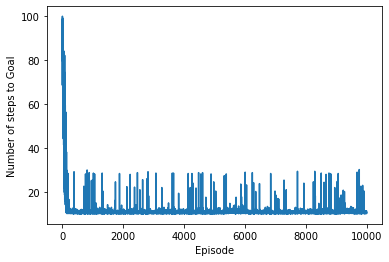

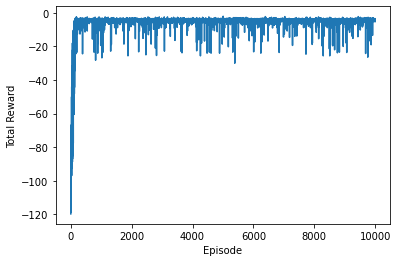

In [83]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

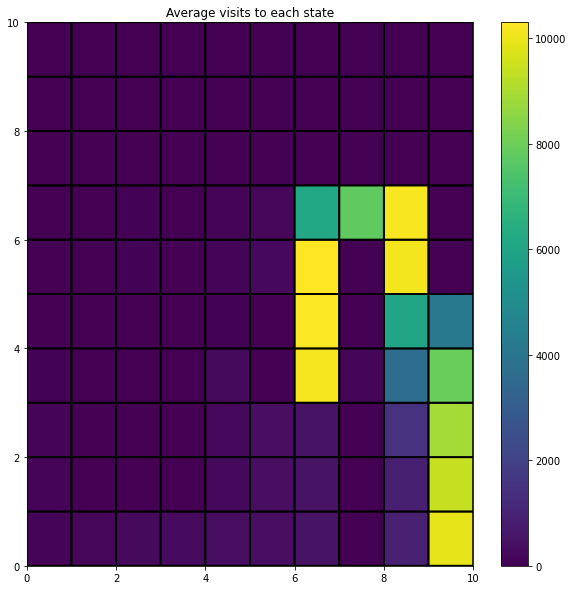

In [84]:
plot_visits(np.average(visits_avgs, 0))

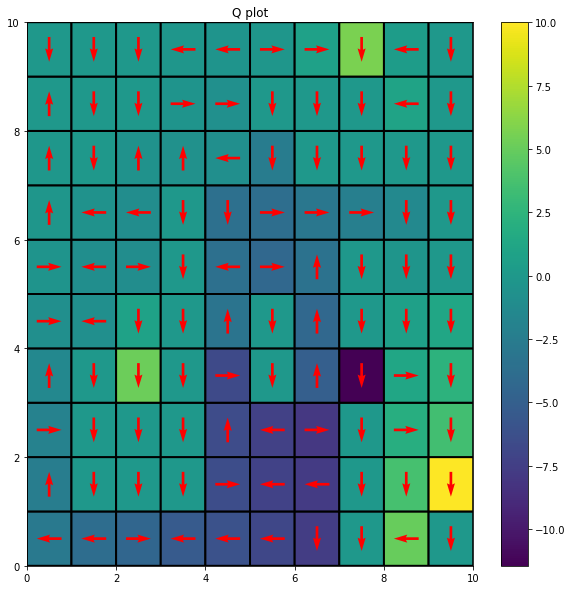

In [85]:
plot_Q(Q)

## Configuration 13

In [86]:
env = create_env(start_state = np.array([[0, 4]]), wind = True)

print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

fun = choose_action_softmax

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


In [87]:
alpha0 = 0.1
gamma = 0.95
beta = 0.15
epsilon0 = 0.01
episodes = 10000

In [88]:
Q_avgs, reward_avgs, steps_avgs, visits_avgs = [], [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((num_rows, num_cols, len(actions)))
    rg = np.random.RandomState(i)
    Q, rewards, steps, visits = sarsa(env, Q, gamma = gamma, choose_action = fun, beta = beta)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)
    visits_avgs.append(visits)

Experiment: 1


100%|██████████| 10000/10000 [00:53<00:00, 185.45it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:54<00:00, 185.12it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:53<00:00, 185.81it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:54<00:00, 183.62it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:54<00:00, 184.38it/s]


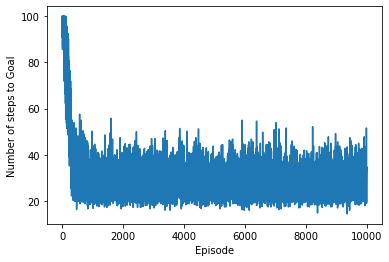

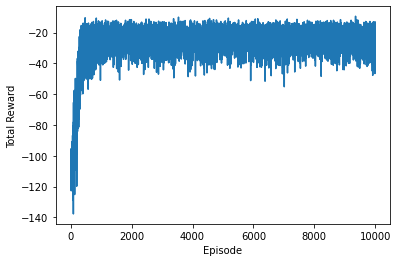

In [89]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

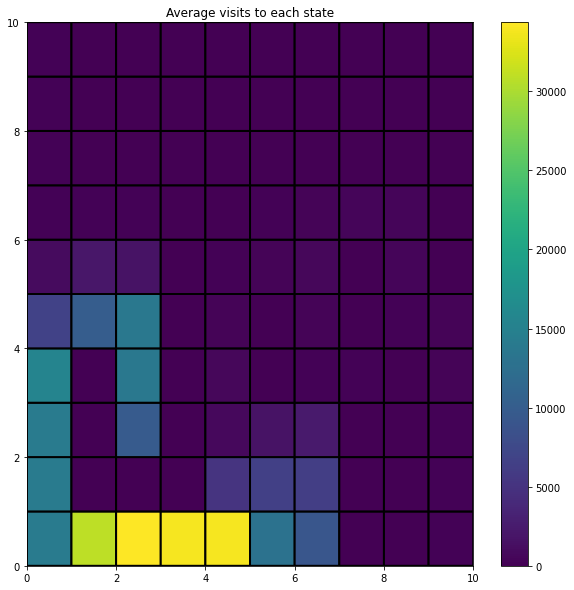

In [90]:
plot_visits(np.average(visits_avgs, 0))

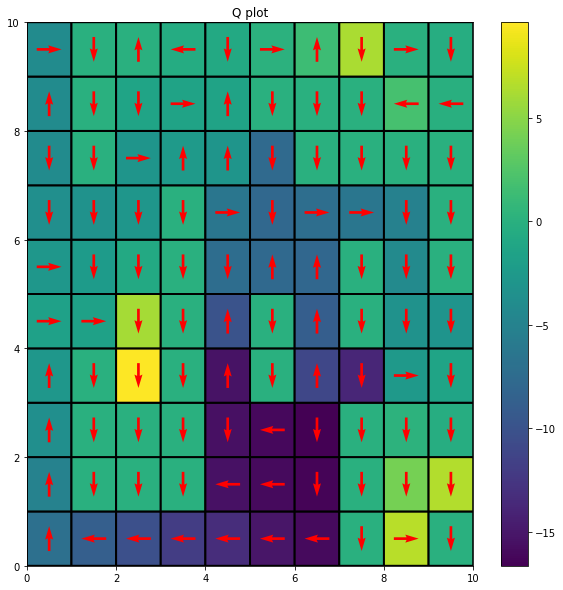

In [91]:
plot_Q(Q)

## Configuration 14

In [92]:
env = create_env(start_state = np.array([[0, 4]]), wind = True)

print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

fun = choose_action_epsilon

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


In [93]:
alpha0 = 0.1
gamma = 0.95
beta = 0.15
epsilon0 = 0.01
episodes = 10000

In [94]:
Q_avgs, reward_avgs, steps_avgs, visits_avgs = [], [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((num_rows, num_cols, len(actions)))
    rg = np.random.RandomState(i)
    Q, rewards, steps, visits = sarsa(env, Q, gamma = gamma, choose_action = fun, beta = epsilon0)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)
    visits_avgs.append(visits)

Experiment: 1


100%|██████████| 10000/10000 [00:28<00:00, 352.37it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:27<00:00, 364.48it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:28<00:00, 350.37it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:28<00:00, 345.79it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:27<00:00, 360.84it/s]


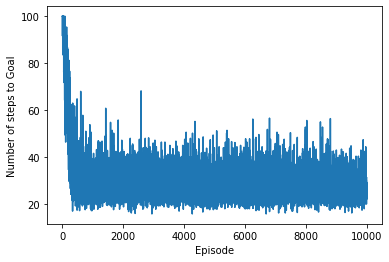

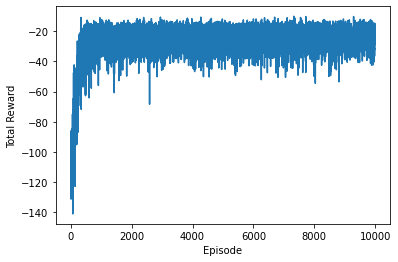

In [95]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

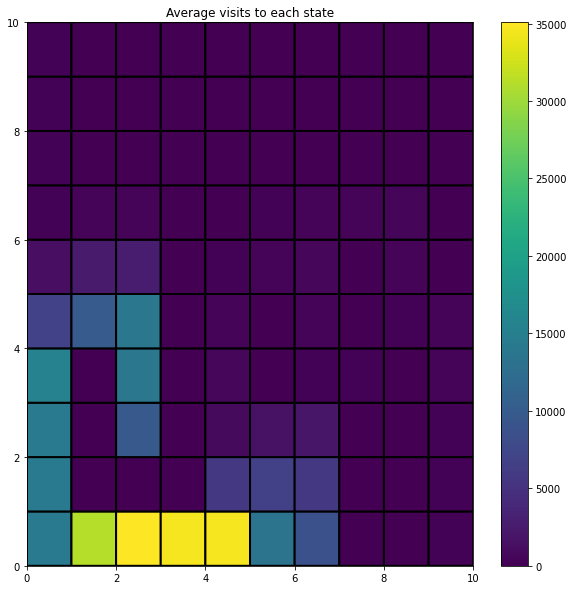

In [96]:
plot_visits(np.average(visits_avgs, 0))

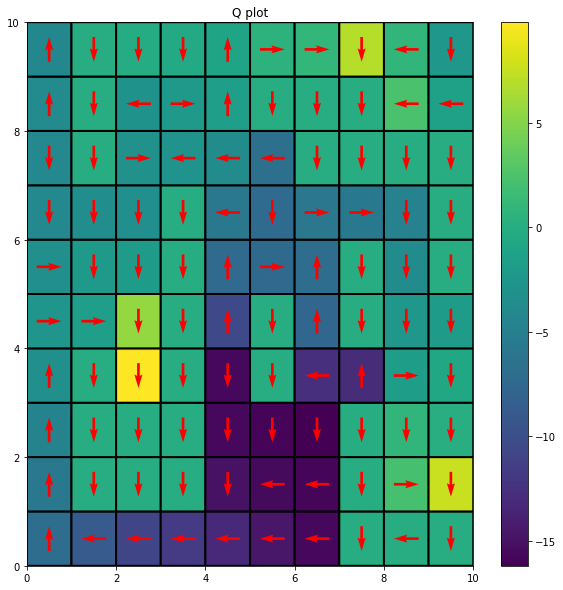

In [97]:
plot_Q(Q)

## Configuration 15

In [98]:
env = create_env(start_state = np.array([[0, 4]]), p = 1, wind = True)

print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

fun = choose_action_softmax

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


In [99]:
alpha0 = 0.1
gamma = 0.95
beta = 0.15
epsilon0 = 0.01
episodes = 10000

In [100]:
Q_avgs, reward_avgs, steps_avgs, visits_avgs = [], [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((num_rows, num_cols, len(actions)))
    rg = np.random.RandomState(i)
    Q, rewards, steps, visits = sarsa(env, Q, gamma = gamma, choose_action = fun, beta = beta)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)
    visits_avgs.append(visits)

Experiment: 1


100%|██████████| 10000/10000 [00:29<00:00, 336.93it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:29<00:00, 340.43it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:29<00:00, 340.14it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:29<00:00, 343.76it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:29<00:00, 341.93it/s]


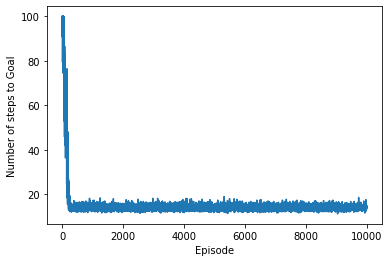

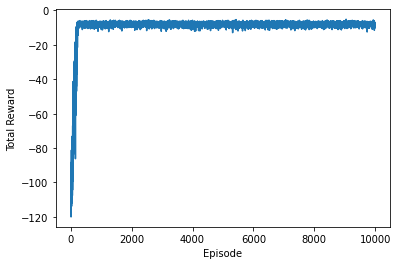

In [101]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

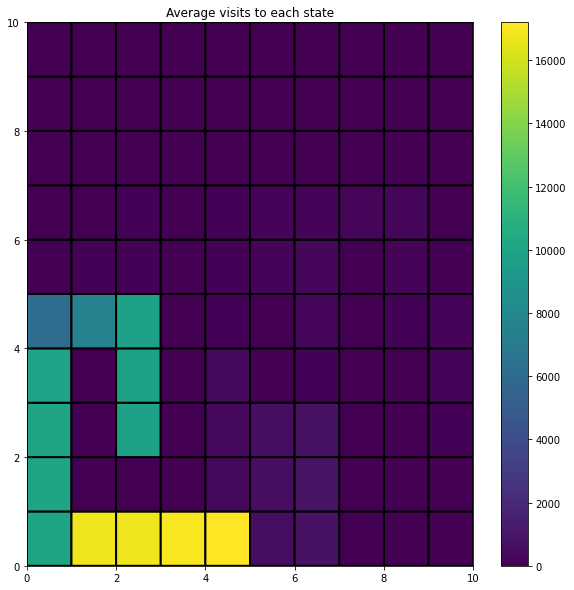

In [102]:
plot_visits(np.average(visits_avgs, 0))

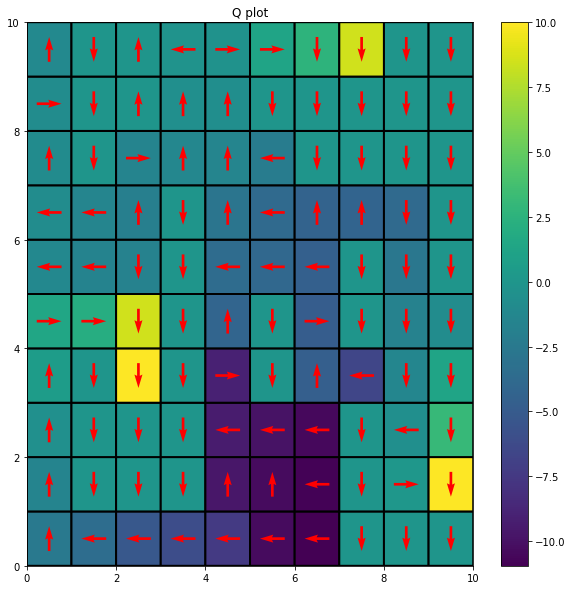

In [103]:
plot_Q(Q)

## Configuration 16

In [104]:
env = create_env(start_state = np.array([[0, 4]]), p = 1, wind = True)

print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

fun = choose_action_epsilon

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


In [105]:
alpha0 = 0.1
gamma = 0.95
beta = 0.15
epsilon0 = 0.01
episodes = 10000

In [106]:
Q_avgs, reward_avgs, steps_avgs, visits_avgs = [], [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((num_rows, num_cols, len(actions)))
    rg = np.random.RandomState(i)
    Q, rewards, steps, visits = sarsa(env, Q, gamma = gamma, choose_action = fun, beta = epsilon0)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)
    visits_avgs.append(visits)

Experiment: 1


100%|██████████| 10000/10000 [00:15<00:00, 642.14it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:15<00:00, 637.46it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:15<00:00, 645.57it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:15<00:00, 644.38it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:15<00:00, 641.75it/s]


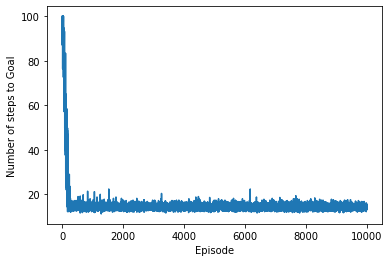

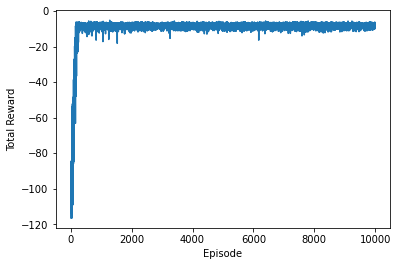

In [107]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

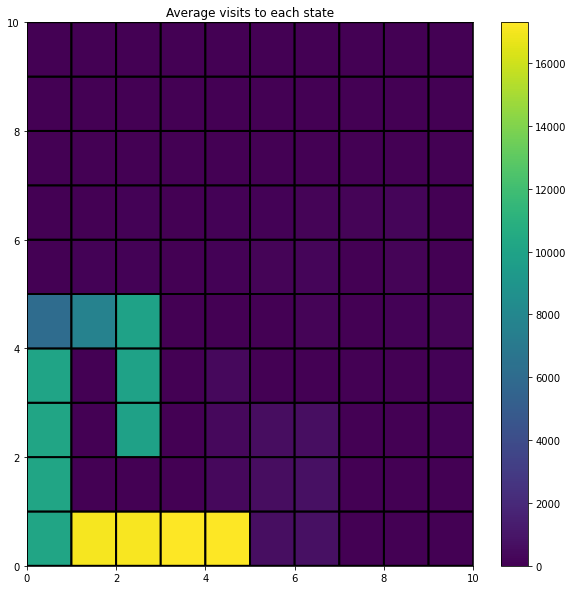

In [108]:
plot_visits(np.average(visits_avgs, 0))

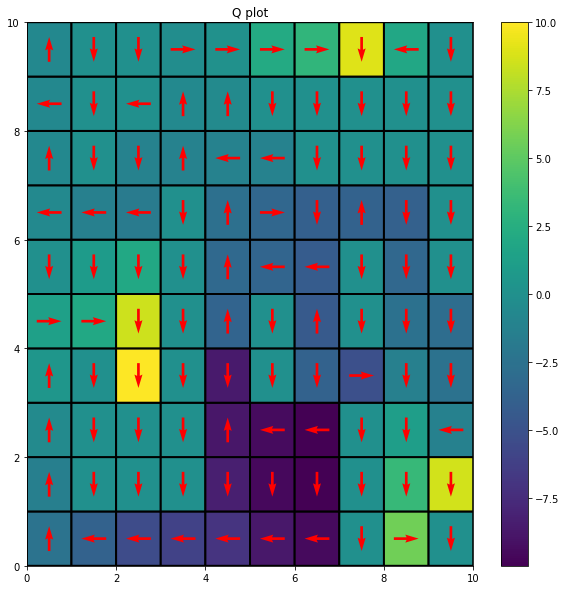

In [109]:
plot_Q(Q)